# CSE 291 Assignment 2 BiLSTM CRF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/UCSD/NLP/Models'

/content/drive/MyDrive/UCSD/NLP/Models


## Download Data/Eval Script




In [14]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

--2021-05-25 06:24:22--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.3’

conlleval.py.3      100%[===================>]   7.33K  --.-KB/s    in 0.001s  

2021-05-25 06:24:22 (7.24 MB/s) - ‘conlleval.py.3’ saved [7502/7502]

--2021-05-25 06:24:22--  https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745734 (728K) [text/plai

In [15]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Preparation

In [16]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
#label_vocab = Vocab(train_label_counter, specials=(), min_freq=1) #for BiLSTM without CRF
label_vocab = Vocab(train_label_counter, specials=(START_TAG, STOP_TAG), min_freq=1)  # for BiLSTM with CRF
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3947 symbols.
Train label vocab: 10 symbols: ['<start>', '<stop>', 'O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


In [17]:
# helper functions

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.logsumexp(vec - max_score_broadcast, dim = 1)


## BiLSTMTagger with CRF

In [18]:
# Implementing a BiLSTM CRF Tagger 
# which uses viterbi decoding algorithm

class BiLSTM_CRF_Tagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTM_CRF_Tagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

        # defining transition probabilities
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size)).to(device)
        # defining constraints for start and stop tags explicitly
        self.transitions.data[label_vocab.stoi[START_TAG], :] = -10000.0
        self.transitions.data[:, label_vocab.stoi[STOP_TAG]] = -10000.0

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence)).view(len(sentence), 1, -1)
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out.view(len(sentence), self.hidden_dim)
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        # print('Shape of Features:', bilstm_feats)
        return bilstm_feats

    def forward_algorithm(self, features):

        init_alphas = torch.full((1, self.tagset_size), fill_value = -10000.0).to(device)
        init_alphas[0][label_vocab.stoi[START_TAG]] = 0.0
        forward_var = init_alphas
  
        for feature in features:

            emit_score = feature.view(-1, 1)
            tag_var = forward_var + self.transitions + emit_score
            # max_tag_var, _ = torch.max(tag_var, dim=1)
            # tag_var = tag_var - max_tag_var.view(-1, 1)
            # forward_var = max_tag_var + torch.logsumexp(tag_var, dim = 1).view(1, -1)
            forward_var = torch.logsumexp(tag_var, dim = 1).view(1, -1)
        
        terminal_var = (forward_var + self.transitions[label_vocab.stoi[STOP_TAG]]).view(1, -1)
        alpha = torch.logsumexp(terminal_var, dim = 1)
        #print('Alpha for vec:', alpha)
        return alpha
  
    def score_sentence(self, features, tags):

        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([label_vocab.stoi[START_TAG]], dtype=torch.long).to(device), tags])
        
        for i, feature in enumerate(features):
            score = score + self.transitions[tags[i + 1], tags[i]] + feature[tags[i + 1]]
            
        score = score + self.transitions[label_vocab.stoi[STOP_TAG], tags[-1]]
        # print('final score', score)
        return score

    def viterbi_decoding(self, features):
        '''
        backpointers = []

        # Start tag timestep
        init_vvars = torch.full((1, self.tagset_size), -10000.0).to(device)
        init_vvars[0][label_vocab.stoi[START_TAG]] = 0.0

        forward_val = init_vvars
        for feature in features:
            bptrs_t = []
            viterbivars_t = []

            for next_tag in range(self.tagset_size):
                tag_val = forward_val + self.transitions[next_tag]
                best_tag_id = argmax(tag_val)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(tag_val[0][best_tag_id].view(1))
            
            forward_val = (torch.cat(viterbivars_t) + feature).view(1, -1)
            backpointers.append(bptrs_t)
        
        # Stop tag timestep
        terminal_val = forward_val + self.transitions[label_vocab.stoi[STOP_TAG]]
        best_tag_id = argmax(terminal_val)
        path_score = terminal_val[0][best_tag_id]

        # Back pointing to get the best tag ids
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        
        start = best_path.pop()
        assert start == label_vocab.stoi[START_TAG] #Sanity Check
        best_path.reverse()
        #print("NON:", path_score, best_path)
        return path_score, best_path
        '''
        
        backpointers = []
        # analogous to forward
        init_vvars = torch.full((1, self.tagset_size), -10000.0).to(device)
        init_vvars[0][label_vocab.stoi[START_TAG]] = 0.0
        forward_var = init_vvars

        for feat in features:
            next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
            _, bptrs_t = torch.max(next_tag_var, dim=1)
            bptrs_t = bptrs_t.squeeze().data.cpu().numpy()
            next_tag_var = next_tag_var.data.cpu().numpy()
            viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t]
            viterbivars_t = torch.FloatTensor(viterbivars_t).to(device)
            forward_var = viterbivars_t + feat
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[label_vocab.stoi[STOP_TAG]]
        terminal_var.data[label_vocab.stoi[STOP_TAG]] = -10000.0
        terminal_var.data[label_vocab.stoi[START_TAG]] = -10000.0
        
        best_tag_id = argmax(terminal_var.unsqueeze(0))
        path_score = terminal_var[best_tag_id]
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        
        start = best_path.pop()
        assert start == label_vocab.stoi[START_TAG]
        best_path.reverse()
        #print('VECTORISED:',path_score, best_path)
        return path_score, best_path
        
    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        best_score, tag_sequence = self.viterbi_decoding(bilstm_feats)
        return best_score, tag_sequence
    
    def neg_log_likelihood(self, sentence, tags):
        feats = self.compute_lstm_emission_features(sentence)
        forward_score = self.forward_algorithm(feats)
        # print(forward_score)
        gold_score = self.score_sentence(feats, tags)
        # print(gold_score)
        # print(forward_score, gold_score)
        return forward_score - gold_score


## Train / Eval loop for BiLSTM CRF 

In [19]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    epoch_precision = []
    epoch_recall = []
    epoch_f1 = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            # print(sent, tags)
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            #sent = sent.unsqueeze(0) 
            #tags = tags.unsqueeze(0)
            # print(tags, tags.shape)
            loss = model.neg_log_likelihood(sent, tags)
            # print('Loss:',loss)
            # print(loss.shape)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        sent, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss = evaluate(model, valid_data, word_vocab, label_vocab)
        epoch_precision.append(avg_precision)
        epoch_recall.append(avg_recall)
        epoch_f1.append(avg_f1)
        epoch_eval_losses.append(avg_eval_loss)
    return losses_per_epoch, epoch_eval_losses, epoch_precision, epoch_recall, epoch_f1 



def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            #sent = sent.unsqueeze(0)
            #tags = tags.unsqueeze(0)
            losses.append(model.neg_log_likelihood(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq])
            sents.append([word_vocab.itos[i] for i in sent])

    evaluation_metrics = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    avg_precision = evaluation_metrics[0]
    avg_recall = evaluation_metrics[1]
    avg_f1 = evaluation_metrics[2]
    avg_eval_loss = np.mean(losses)
    #print ('dataType:', type(evaluation_metrics))
    print('Avg evaluation loss:', np.mean(losses))
    # print(evaluation_metrics)
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss


## Training for BiLSTM CRF

In [9]:
model_crf = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_crf.parameters(), lr=1e-3)

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model_crf.apply(init_weights)

BiLSTM_CRF_Tagger(
  (word_embeds): Embedding(3947, 128)
  (bilstm): LSTM(128, 128, bidirectional=True)
  (tag_projection_layer): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model_crf.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_crf):,} trainable parameters')

The model has 771,978 trainable parameters


### Epochs = 10

In [39]:
model = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_10, val_loss_10, precision_val_10, recall_val_10, f1_val_10 = train(model, train_data, valid_data, word_vocab, label_vocab, epochs= 10, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.812072196245193
Avg loss over last 500 updates: 8.723561610817908
Avg loss over last 500 updates: 6.913870445966721
Avg loss over last 500 updates: 6.1193063006401065
Avg loss over last 500 updates: 5.3654381604194645
Avg loss over last 500 updates: 5.367027888059616
processed 11170 tokens with 1231 phrases; found: 876 phrases; correct: 459.
accuracy:  43.01%; (non-O)
accuracy:  88.95%; precision:  52.40%; recall:  37.29%; FB1:  43.57
              LOC: precision:  73.21%; recall:  42.15%; FB1:  53.50  209
             MISC: precision:  45.45%; recall:  18.23%; FB1:  26.02  77
              ORG: precision:  42.42%; recall:  31.92%; FB1:  36.43  231
              PER: precision:  48.19%; recall:  46.88%; FB1:  47.53  359
Avg evaluation loss: 4.988049250394106

5 random evaluation samples:
SENT: MILWAUKEE AT CHICAGO
TRUE: I-ORG O I-LOC
PRED: I-ORG O I-LOC
SENT: Interfax news agency said police had <unk> one of the <unk> .
TRUE: I-ORG O O 

### Epochs = 20

In [33]:
model = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, val_loss, precision_val, recall_val, f1_val = train(model, train_data, valid_data, word_vocab, label_vocab, epochs= 20, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 8.89334192276001
Avg loss over last 500 updates: 7.887363713741302
Avg loss over last 500 updates: 6.256924055576325
Avg loss over last 500 updates: 5.6526825466156
Avg loss over last 500 updates: 4.908495579719544
Avg loss over last 500 updates: 5.02231024980545
processed 11170 tokens with 1231 phrases; found: 846 phrases; correct: 491.
accuracy:  46.53%; (non-O)
accuracy:  88.92%; precision:  58.04%; recall:  39.89%; FB1:  47.28
              LOC: precision:  68.40%; recall:  43.53%; FB1:  53.20  231
             MISC: precision:  47.06%; recall:  12.50%; FB1:  19.75  51
              ORG: precision:  59.02%; recall:  35.18%; FB1:  44.08  183
              PER: precision:  52.76%; recall:  54.47%; FB1:  53.60  381
Avg evaluation loss: 4.652096270024776

5 random evaluation samples:
SENT: He is not as <unk> as he used to be be but was too good for me in the end .
TRUE: O O O O O O O O O O O O O O O O O O O O O
PRED: O O O O O O O O O O O

### Epochs = 30

In [13]:
# with init
train_loss_30i, val_loss_30i, precision_val_30i, recall_val_30i, f1_val_30i = train(model_crf, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 11.77340892446041
Avg loss over last 500 updates: 8.069066550731659
Avg loss over last 500 updates: 6.016368812084198
Avg loss over last 500 updates: 5.442516035079956
Avg loss over last 500 updates: 4.687651633739471
Avg loss over last 500 updates: 4.588619255304336
processed 11170 tokens with 1231 phrases; found: 1212 phrases; correct: 531.
accuracy:  50.94%; (non-O)
accuracy:  89.34%; precision:  43.81%; recall:  43.14%; FB1:  43.47
              LOC: precision:  74.16%; recall:  54.55%; FB1:  62.86  267
             MISC: precision:  32.14%; recall:  23.44%; FB1:  27.11  140
              ORG: precision:  25.88%; recall:  28.66%; FB1:  27.20  340
              PER: precision:  43.01%; recall:  54.20%; FB1:  47.96  465
Avg evaluation loss: 4.826706733629107

5 random evaluation samples:
SENT: Haga had the <unk> of <unk> the <unk> lap at <unk> kph .
TRUE: I-PER O O O O O O O O O O O O
PRED: I-ORG O O O O O O O O O O O O
SENT: FC <unk> 0

In [20]:
model_crfn = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_crfn.parameters(), lr=1e-3)
train_loss_30, val_loss_30, precision_val_30, recall_val_30, f1_val_30 = train(model_crfn, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)
torch.save(model_crfn.state_dict(), 'model_30_cpu.pt')

--- EPOCH 0 ---
Avg loss over last 500 updates: 10.922913804292678
Avg loss over last 500 updates: 8.740891838550567
Avg loss over last 500 updates: 6.768209879398346
Avg loss over last 500 updates: 5.950845903396607
Avg loss over last 500 updates: 5.048523798704148
Avg loss over last 500 updates: 5.180367069840432
processed 11170 tokens with 1231 phrases; found: 763 phrases; correct: 464.
accuracy:  44.44%; (non-O)
accuracy:  88.90%; precision:  60.81%; recall:  37.69%; FB1:  46.54
              LOC: precision:  74.76%; recall:  43.25%; FB1:  54.80  210
             MISC: precision:  44.44%; recall:  16.67%; FB1:  24.24  72
              ORG: precision:  56.72%; recall:  37.13%; FB1:  44.88  201
              PER: precision:  57.50%; recall:  43.63%; FB1:  49.61  280
Avg evaluation loss: 4.660797813981771

5 random evaluation samples:
SENT: The Greek <unk> party 's executive bureau gave the <unk> light to Prime Minister <unk> <unk> to call <unk> elections , its general secretary <unk>

In [44]:
# save model
torch.save(model.state_dict(), 'model_30.pt')

In [ ]:
# load model
model.load_state_dict(torch.load('model_30.pt', map_location=torch.device('cpu')))

### Epochs = 40

In [48]:
model = BiLSTM_CRF_Tagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_40, val_loss_40, precision_val_40, recall_val_40, f1_val_40 = train(model, train_data, valid_data, word_vocab, label_vocab, epochs= 40, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 10.086181541919709
Avg loss over last 500 updates: 8.777078891754151
Avg loss over last 500 updates: 7.1188524394035335
Avg loss over last 500 updates: 6.231185553073883
Avg loss over last 500 updates: 5.299673834323883
Avg loss over last 500 updates: 5.4465765759944915
processed 11170 tokens with 1231 phrases; found: 844 phrases; correct: 459.
accuracy:  43.72%; (non-O)
accuracy:  89.38%; precision:  54.38%; recall:  37.29%; FB1:  44.24
              LOC: precision:  71.70%; recall:  41.87%; FB1:  52.87  212
             MISC: precision:  58.46%; recall:  19.79%; FB1:  29.57  65
              ORG: precision:  44.20%; recall:  32.25%; FB1:  37.29  224
              PER: precision:  49.56%; recall:  46.07%; FB1:  47.75  343
Avg evaluation loss: 4.919881877303124

5 random evaluation samples:
SENT: " I will be happy to give him the award <unk> on January 0000 in <unk> and I 'm <unk> that Costa himself will be there <unk> me on that day to <

## Evaluations

In [16]:
import matplotlib.pyplot as plt
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Epochs = 40

In [54]:
N_EPOCHS = 40
x = [i+1 for i in range(N_EPOCHS)]

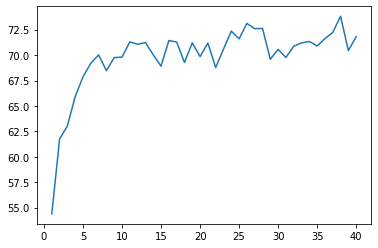

In [55]:
plt.plot(x,precision_val_40)

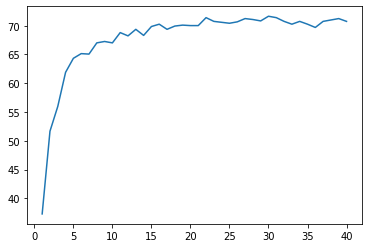

In [56]:
plt.plot(x,recall_val_40)

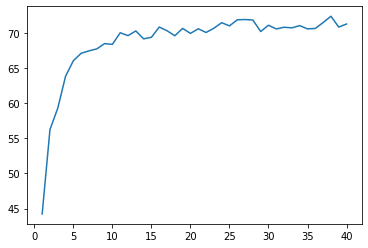

In [57]:
plt.plot(x,f1_val_40)

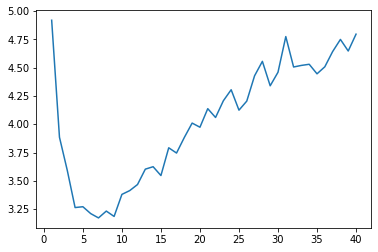

In [58]:
plt.plot(x,val_loss_40)

### Epochs = 30 --- FINAL with model saved

In [17]:
N_EPOCHS = 30
x = [i+1 for i in range(N_EPOCHS)]

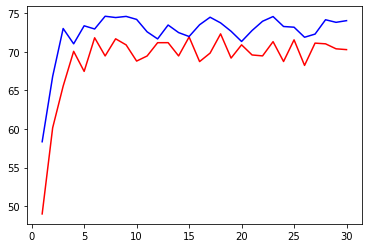

In [46]:
plt.plot(x,precision_val_30, color = 'red')
plt.plot(x,precision_val_30b, color = 'blue')

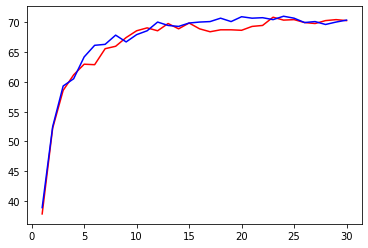

In [47]:
plt.plot(x,recall_val_30, color= 'red')
plt.plot(x,recall_val_30b, color = 'blue')

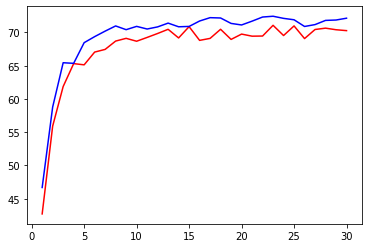

In [48]:
plt.plot(x,f1_val_30, color = 'red')
plt.plot(x,f1_val_30b, color='blue')

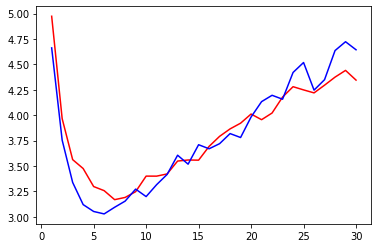

In [49]:
plt.plot(x,val_loss_30, color = 'red')
plt.plot(x,val_loss_30b, color = 'blue')

#### With inits epochs = 30

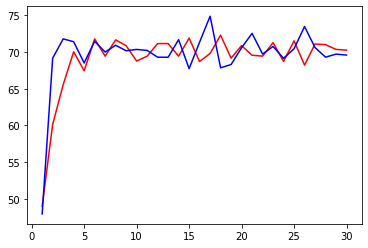

In [63]:
plt.plot(x,precision_val_30, color = 'red')
plt.plot(x,precision_val_30bi, color = 'blue')

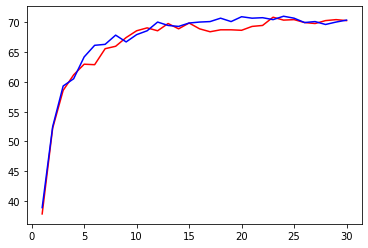

In [64]:
plt.plot(x,recall_val_30, color= 'red')
plt.plot(x,recall_val_30b, color = 'blue')

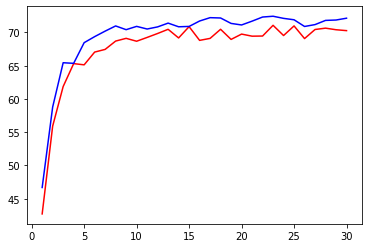

In [65]:
plt.plot(x,f1_val_30, color = 'red')
plt.plot(x,f1_val_30b, color='blue')

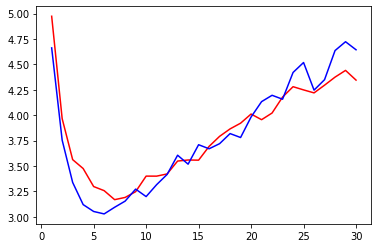

In [66]:
plt.plot(x,val_loss_30, color = 'red')
plt.plot(x,val_loss_30b, color = 'blue')

### CFR GOOOOOOOD

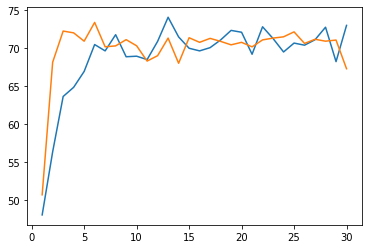

In [38]:
plt.plot(x, precision_val_30)
plt.plot(x, precision_val_30bi)

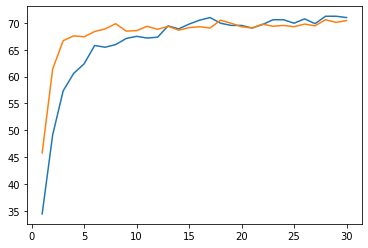

In [37]:
plt.plot(x,recall_val_30)
plt.plot(x,recall_val_30bi)

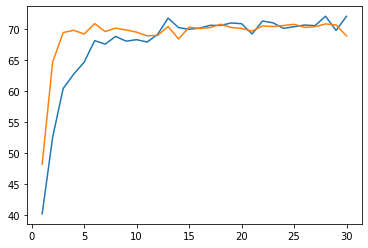

In [36]:
plt.plot(x,f1_val_30)
plt.plot(x,f1_val_30bi)

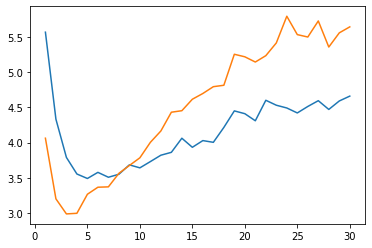

In [35]:
plt.plot(x,val_loss_30)
plt.plot(x,val_loss_30bi)

### Epochs = 20

In [34]:
import matplotlib.pyplot as plt
plt.figure()
N_EPOCHS = 20
x = [i+1 for i in range(N_EPOCHS)]

<Figure size 432x288 with 0 Axes>

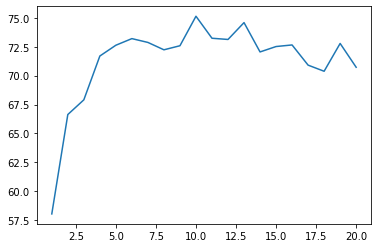

In [35]:
#plot precision
plt.plot(x,precision_val)

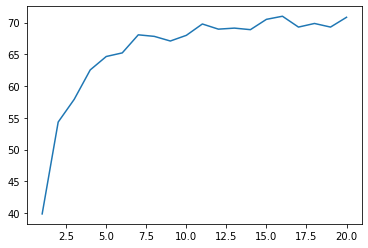

In [36]:
# plot recall
plt.plot(x, recall_val)

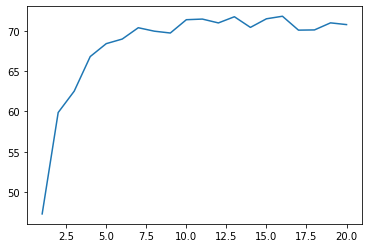

In [37]:
# plot f1 score
plt.plot(x, f1_val)

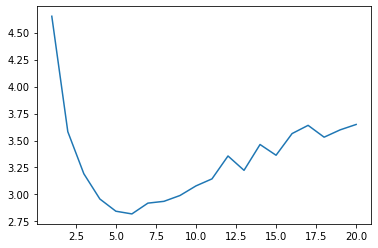

In [38]:
# plot validation loss per epoch
plt.plot(x, val_loss)

### Epochs = 10

In [40]:
N_EPOCHS = 10
x = [i+1 for i in range(N_EPOCHS)]

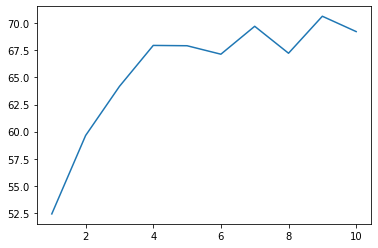

In [41]:
#plot precision
plt.plot(x,precision_val_10)

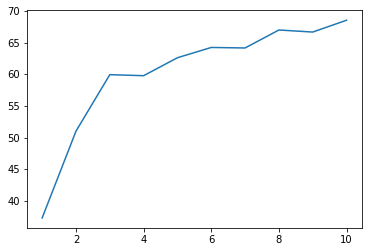

In [42]:
#plot recall
plt.plot(x,recall_val_10)

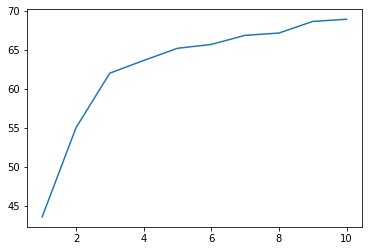

In [43]:
#plot f1
plt.plot(x, f1_val_10)

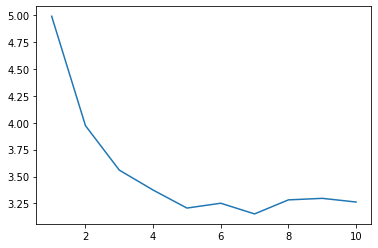

In [44]:
#plot validation loss per epoch
plt.plot(x, val_loss_10)

### Stacked

In [ ]:
precision_val_10

## Data Preparation Baseline

In [9]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1) #for BiLSTM without CRF
#label_vocab = Vocab(train_label_counter, specials=(START_TAG, STOP_TAG), min_freq=1)  # for BiLSTM with CRF
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

Train word vocab: 3947 symbols.
Train label vocab: 8 symbols: ['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
Train data: 3420 sentences.
Valid data: 800
Pusan 0000 0000 0000 0000 0000 0000
I-ORG O O O O O O
Earlier this month , <unk> denied a Kabul government statement that the two sides had agreed to a ceasefire in the north .
O O O O I-PER O O I-LOC O O O O O O O O O O O O O O O


## BiLSTM Tagger Baseline

In [10]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats

    
    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size), 
              tags.view(-1), 
              reduction='sum'
            )

## Train/Eval Loop for BiLSTM Baseline

In [11]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    epoch_precision = []
    epoch_recall = []
    epoch_f1 = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        sent, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss = evaluate(model, valid_data, word_vocab, label_vocab)
        epoch_precision.append(avg_precision)
        epoch_recall.append(avg_recall)
        epoch_f1.append(avg_f1)
        epoch_eval_losses.append(avg_eval_loss)
    return losses_per_epoch, epoch_eval_losses, epoch_precision, epoch_recall, epoch_f1 

def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    evaluation_metrics = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    avg_precision = evaluation_metrics[0]
    avg_recall = evaluation_metrics[1]
    avg_f1 = evaluation_metrics[2]
    avg_eval_loss = np.mean(losses)
    print('Avg evaluation loss:', np.mean(losses))
    
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return sents, true_tags, pred_tags, avg_precision, avg_recall, avg_f1, avg_eval_loss

## Training for BiLSTM Baseline

In [30]:
model_b = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model_b.parameters(), lr=1e-3)

In [31]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model_b.apply(init_weights)

BiLSTMTagger(
  (word_embeds): Embedding(3947, 128)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (tag_projection_layer): Linear(in_features=256, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_b):,} trainable parameters')

The model has 771,464 trainable parameters


### Epoch = 30 

In [34]:
# with weights init
train_loss_30bi, val_loss_30bi, precision_val_30bi, recall_val_30bi, f1_val_30bi= train(model_b, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 10.200347526799888
Avg loss over last 500 updates: 7.307830089251511
Avg loss over last 500 updates: 5.5194844926636435
Avg loss over last 500 updates: 4.791389833866619
Avg loss over last 500 updates: 4.142791631330765
Avg loss over last 500 updates: 3.952842463378271
processed 11170 tokens with 1231 phrases; found: 1112 phrases; correct: 564.
accuracy:  52.64%; (non-O)
accuracy:  90.51%; precision:  50.72%; recall:  45.82%; FB1:  48.14
              LOC: precision:  63.48%; recall:  60.33%; FB1:  61.86  345
             MISC: precision:  53.93%; recall:  25.00%; FB1:  34.16  89
              ORG: precision:  39.18%; recall:  31.27%; FB1:  34.78  245
              PER: precision:  46.42%; recall:  54.47%; FB1:  50.12  433
Avg evaluation loss: 4.0627051913819745

5 random evaluation samples:
SENT: CINCINNATI AT ATLANTA
TRUE: I-ORG O I-LOC
PRED: I-LOC O I-ORG
SENT: George <unk> <unk> president in 0000 on his <unk> campaign and Clinton won 

In [41]:
torch.save(model_b.state_dict(), 'model_baseline_30inits.pt')

## Epochs = 30

In [12]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_30b, val_loss_30b, precision_val_30b, recall_val_30b, f1_val_30b = train(model, train_data, valid_data, word_vocab, label_vocab, epochs= 30, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.423182636022569
Avg loss over last 500 updates: 8.135430105037987
Avg loss over last 500 updates: 6.604891209734604
Avg loss over last 500 updates: 5.771901991735213
Avg loss over last 500 updates: 5.044115421846975
Avg loss over last 500 updates: 5.12113966058055
processed 11170 tokens with 1231 phrases; found: 727 phrases; correct: 463.
accuracy:  43.12%; (non-O)
accuracy:  89.68%; precision:  63.69%; recall:  37.61%; FB1:  47.29
              LOC: precision:  78.72%; recall:  40.77%; FB1:  53.72  188
             MISC: precision:  54.67%; recall:  21.35%; FB1:  30.71  75
              ORG: precision:  58.46%; recall:  37.13%; FB1:  45.42  195
              PER: precision:  59.48%; recall:  43.36%; FB1:  50.16  269
Avg evaluation loss: 4.657768424530004

5 random evaluation samples:
SENT: The town 's <unk> <unk> ground is <unk> only by two <unk> <unk> .
TRUE: O O O O O O O O O O O O O O
PRED: O O O O O O O O O O O O O O
SENT: <unk> , 

In [13]:
torch.save(model.state_dict(), 'model_baseline_30_withoutinits.pt')

In [ ]:
model.load_state_dict(torch.load('model_baseline_30i.pt', map_location=torch.device('cpu')))

###Other shit

In [ ]:
# Train BiLSTM Tagger Baseline
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, epochs=10, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.350399366080762
Avg loss over last 500 updates: 8.307334659717977
Avg loss over last 500 updates: 6.599177786468529
Avg loss over last 500 updates: 5.8010076814573255
Avg loss over last 500 updates: 5.0647571972454895
Avg loss over last 500 updates: 5.128686685073073
Avg evaluation loss: 4.800561979092236
processed 11170 tokens with 1231 phrases; found: 816 phrases; correct: 499.
accuracy:  45.93%; (non-O)
accuracy:  89.54%; precision:  61.15%; recall:  40.54%; FB1:  48.75
              LOC: precision:  82.02%; recall:  40.22%; FB1:  53.97  178
             MISC: precision:  64.62%; recall:  21.88%; FB1:  32.68  65
              ORG: precision:  55.81%; recall:  39.09%; FB1:  45.98  215
              PER: precision:  53.35%; recall:  51.76%; FB1:  52.54  358
(61.15196078431373, 40.53614947197401, 48.75427454811919)

5 random evaluation samples:
SENT: Add men 's singles , second round 0000 - Todd Martin ( U.S. ) beat Andrea Gaudenzi ( It

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, epochs=20, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.392168501645326
Avg loss over last 500 updates: 8.281112756833434
Avg loss over last 500 updates: 6.518730931034312
Avg loss over last 500 updates: 5.761171801753342
Avg loss over last 500 updates: 5.088793627198785
Avg loss over last 500 updates: 5.1303387298511804
Avg evaluation loss: 4.7958146422277785
processed 11170 tokens with 1231 phrases; found: 739 phrases; correct: 460.
accuracy:  43.12%; (non-O)
accuracy:  89.51%; precision:  62.25%; recall:  37.37%; FB1:  46.70
              LOC: precision:  80.68%; recall:  39.12%; FB1:  52.69  176
             MISC: precision:  55.36%; recall:  16.15%; FB1:  25.00  56
              ORG: precision:  60.49%; recall:  31.92%; FB1:  41.79  162
              PER: precision:  54.78%; recall:  51.22%; FB1:  52.94  345
(62.24627875507443, 37.36799350121852, 46.7005076142132)

5 random evaluation samples:
SENT: <unk> <unk> ( Czech Republic ) beat <unk> <unk> ( Japan ) 6- 0000 3-6 7-5
TRUE: I-PER I-

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, epochs=40, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.32098669219017
Avg loss over last 500 updates: 8.216664522800595
Avg loss over last 500 updates: 6.596626217706129
Avg loss over last 500 updates: 5.695464440650772
Avg loss over last 500 updates: 5.06097520387359
Avg loss over last 500 updates: 5.171798341202957
Avg evaluation loss: 4.706221709033307
processed 11170 tokens with 1231 phrases; found: 758 phrases; correct: 458.
accuracy:  43.56%; (non-O)
accuracy:  89.22%; precision:  60.42%; recall:  37.21%; FB1:  46.05
              LOC: precision:  77.72%; recall:  39.39%; FB1:  52.29  184
             MISC: precision:  46.38%; recall:  16.67%; FB1:  24.52  69
              ORG: precision:  61.45%; recall:  35.83%; FB1:  45.27  179
              PER: precision:  53.07%; recall:  46.88%; FB1:  49.78  326
(60.4221635883905, 37.205523964256706, 46.05329311211664)

5 random evaluation samples:
SENT: <unk> <unk> ( U.S. ) beat <unk> <unk> ( Netherlands ) 5-7 6-3 6-3
TRUE: I-PER I-PER O I-LOC

In [ ]:
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_data, valid_data, word_vocab, label_vocab, epochs=25, log_interval=500)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.283617741703987
Avg loss over last 500 updates: 8.075437951177358
Avg loss over last 500 updates: 6.559844582330435
Avg loss over last 500 updates: 5.741006248389371
Avg loss over last 500 updates: 5.002380748537835
Avg loss over last 500 updates: 5.099594749702839
Avg evaluation loss: 4.678753530844115
processed 11170 tokens with 1231 phrases; found: 782 phrases; correct: 477.
accuracy:  44.11%; (non-O)
accuracy:  89.37%; precision:  61.00%; recall:  38.75%; FB1:  47.39
              LOC: precision:  77.27%; recall:  42.15%; FB1:  54.55  198
             MISC: precision:  67.24%; recall:  20.31%; FB1:  31.20  58
              ORG: precision:  57.45%; recall:  35.18%; FB1:  43.64  188
              PER: precision:  52.37%; recall:  47.97%; FB1:  50.07  338
(60.99744245524297, 38.74898456539399, 47.3919523099851)

5 random evaluation samples:
SENT: <unk> Munich 0000 0000 0000 0000 0000 0000 0000
TRUE: I-ORG I-ORG O O O O O O O
PRED: I-OR

###BEST EVAL ---- Monday Night

In [23]:
import matplotlib.pyplot as plt

In [21]:
N_EPOCHS = 30
x = [i+1 for i in range(N_EPOCHS)]

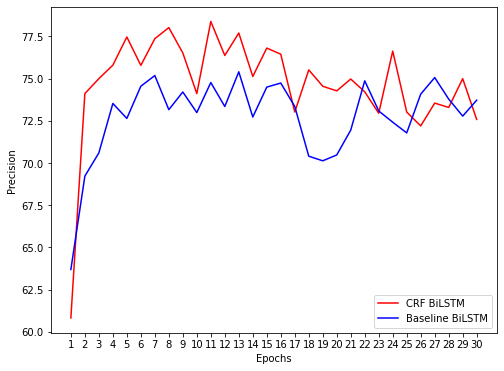

In [51]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.plot(x,precision_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,precision_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc ='lower right')

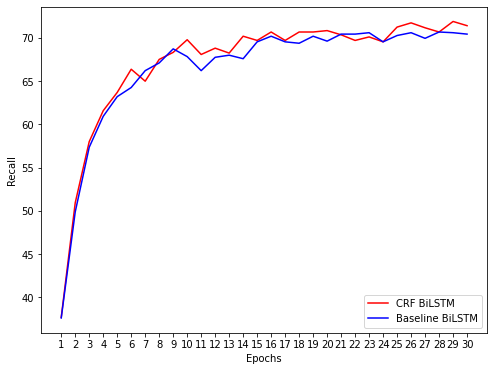

In [53]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.plot(x,recall_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,recall_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc = 'lower right')

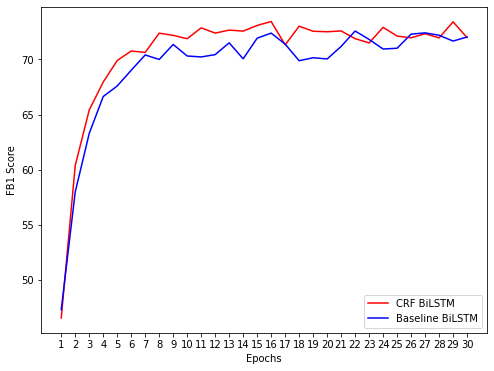

In [54]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('FB1 Score')
plt.plot(x,f1_val_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,f1_val_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc = 'lower right')

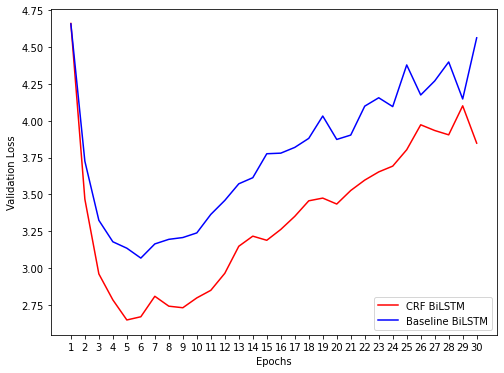

In [56]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(x,val_loss_30, color = 'red', label ='CRF BiLSTM')
plt.plot(x,val_loss_30b, color = 'blue', label = 'Baseline BiLSTM')
plt.legend(loc = 'lower right')

In [35]:
avg_train_loss_30 = [sum(i)/len(i) for i in train_loss_30]

In [36]:
avg_train_loss_30b = [sum(i)/len(i) for i in train_loss_30b]

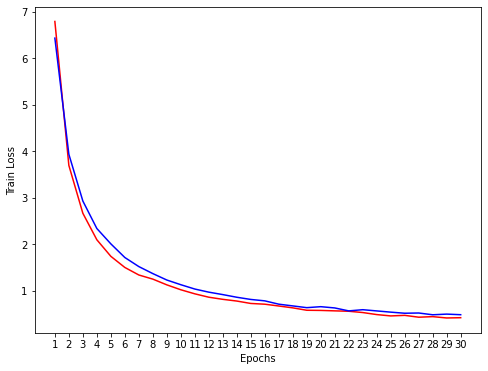

In [57]:
plt.figure(figsize = (8,6))
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(x,avg_train_loss_30, color = 'red', label = 'CRF BiLSTM')
plt.plot(x,avg_train_loss_30b, color = 'blue', label = 'Baseline BiLSTM')